# ML Практическая работа 3
## Мурадян Денис

### LDA/QDA and Probabilistic LSA

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


## Цели и задачи работы

**Цель.** Применить и сравнить алгоритмы классификации **LDA** и **QDA** на табличных признаках датасета объявлений о продаже авто, а также выполнить тематическое моделирование текстов описаний с помощью **Probabilistic LSA (pLSA, EM-алгоритм)**. Оценить качество по требуемым метрикам и сделать выводы о *уместности* методов для выбранного датасета.

**Задачи:**
1. Дать краткую теоретическую справку по **LDA**, **QDA**, **pLSA** (назначение, предпосылки, ограничения).
2. Загрузить очищенный датасет; сформировать целевую переменную `target = (price > median(price))`; подготовить табличные признаки и текстовый корпус `description`.
3. Проверить **дисбаланс классов**, **корреляции между признаками** и **связь признаков с целевой**; при необходимости скорректировать набор фич/регуляризацию.
4. Обучить **LDA/QDA** (регуляризация: `shrinkage` для LDA, `reg_param` для QDA); **подобрать гиперпараметры по Accuracy на валидации**; финально оценить на тесте.
5. Построить **Probabilistic LSA**: сформировать матрицу **счётчиков слов (bag-of-words)**, обучить pLSA **EM-алгоритмом** для разных чисел тем `K`, выбрать `K` по **Perplexity** на валидации; 
6. **Метрики:**  
   - для **LDA/QDA** - основная **Accuracy** (дополнительно можно приводить F1/ROC AUC/LogLoss как вспомогательные);  
   - для **pLSA** - **Perplexity**
7. Визуализировать ключевые результаты (heatmap корреляций, ROC-кривые для LDA/QDA, график Perplexity vs K для pLSA) и сформулировать выводы по каждому алгоритму.

*Примечание:* базовые шаги предобработки берем из предыдущей работы, проверим на дисбаланс и корреляции.

## Теоретическая справка

В этой работе рассматриваются три алгоритма: **Linear Discriminant Analysis (LDA)**, **Quadratic Discriminant Analysis (QDA)** и **Probabilistic Latent Semantic Analysis (pLSA)**.  
Ниже приведено краткое описание теоретических основ каждого метода.

### Linear Discriminant Analysis (LDA)

**Назначение**  
LDA - метод классификации, который ищет линейные разделяющие поверхности между классами, предполагая, что данные внутри каждого класса распределены по многомерному нормальному закону с разными средними, но общей ковариационной матрицей.

**Основные идеи**
- Каждый класс описывается нормальным распределением  
  $ p(x \mid y=k) = \mathcal{N}(\mu_k, \Sigma) $  с общей ковариацией $\Sigma$
- Классификация строится по максимизации апостериорной вероятности  
  $ p(y=k \mid x) $  
  через теорему Байеса.
- В результате получаются **линейные разделяющие границы**.

**Преимущества** Простота, интерпретируемость, высокая скорость работы.  
**Недостатки** Плохо подходит при сильных различиях ковариаций классов или при наличии выраженной нелинейности.  

### Quadratic Discriminant Analysis (QDA)

**Назначение**  
QDA расширяет LDA, ослабляя предположение об одинаковых ковариациях для всех классов. Позволяет моделировать более сложные, **криволинейные** границы между классами.

**Основные идеи**
- Каждый класс имеет собственную ковариационную матрицу $\Sigma_k$
- Классификация также основана на максимизации апостериорной вероятности, но теперь границы между классами становятся **квадратичными**.

**Преимущества** Гибкость и возможность точнее учитывать различия между классами.  
**Недостатки** Требует больше данных для устойчивой оценки $\Sigma_k$ чувствителен к мультиколлинеарности и шуму.  

### Probabilistic Latent Semantic Analysis (pLSA)

**Идея**  
pLSA - это вероятностная тематическая модель, которая используется для выявления скрытых тем в коллекции документов. Каждый документ рассматривается как смесь нескольких тем, а каждая тема - как распределение вероятностей по словам. Модель помогает понять, какие скрытые смысловые структуры присутствуют в текстах.

**Как работает**  
- Документы и слова связываются через скрытую переменную - **тему**.  
- Вероятность встретить слово $w$ в документе $d$ выражается как сумма по всем темам:  
  $p(w|d) = \sum_t p(w|t) \, p(t|d)$  
  где $p(w|t)$ - распределение слов внутри темы, а $p(t|d)$ - распределение тем в документе. Таким образом, pLSA пытается аппроксимировать исходную матрицу "документы-слова" как комбинацию двух вероятностных матриц:  
  *распределений слов по темам* и *тем по документам*.

**Обучение**  
Параметры модели оцениваются методом **максимального правдоподобия** с помощью **EM-алгоритма (Expectation–Maximization)**:  
- **E-шаг:** вычисляется вероятность того, что слово в документе принадлежит каждой теме.  
- **M-шаг:** обновляются распределения слов по темам и тем по документам на основе найденных вероятностей.  
Алгоритм повторяется, пока не стабилизируется логарифм правдоподобия модели.

**Оценка качества**  
Главная метрика - **Perplexity**, которая показывает, насколько хорошо модель описывает тексты:  
чем меньше значение перплексии, тем точнее модель предсказывает распределения слов.  
Для проверки на новых данных фиксируются распределения тем по словам, а обновляются только распределения тем по документам.

## Подготовка данных

Делаем ровно как в дз2, только дополнительно **сохраняем `description` для pLSA**:

1. Сохраняем тексты `description` в отдельный датафрейм для тематического моделирования.
2. Удаляем лишние колонки из табличной части: `id`, `description`, `posting_date`.
3. Булевы признаки -> `int (0/1)`.
4. Дроп строк с пропусками в `title_status`.
5. Формируем таргет: `target = (price > median(price))`.
6. Удаляем `price` из признаков.
7. Проверяем баланс классов (counts и проценты).
8. Сплиты `train/valid/test` со `stratify`.
9. Масштабируем числовые признаки `StandardScaler`.


Количество пропусков в каждом признаке:
price                  0
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
dtype: int64

Распределение целевой переменной:
target
0    0.500536
1    0.499464
Name: proportion, dtype: float64
Распределение классов
Всего объектов: 173566
Класс 0: 86876 (0.501)
Класс 1: 86690 (0.499)
Imbalance Ratio (IR): 1.002
Baseline Accuracy (всегда предсказывать класс 0): 0.501


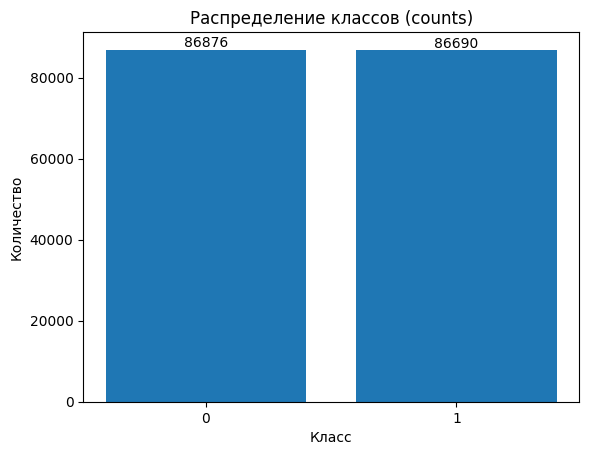

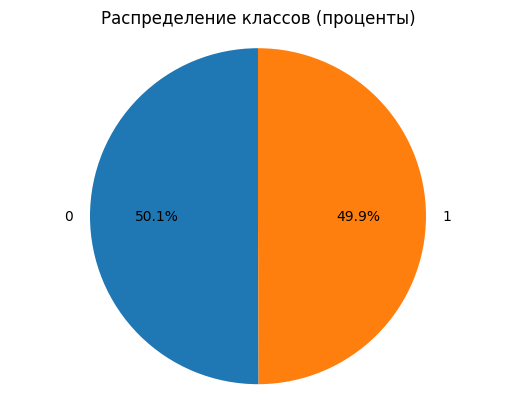

Train shape: (121491, 19)
Valid shape: (26040, 19)
Test shape: (26035, 19)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

texts = df[['description']].copy()

df = df.drop(columns=['id', 'description', 'posting_date'])

bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

df = df.dropna(subset=['title_status'])
print("Количество пропусков в каждом признаке:")
print(df.isna().sum())

median_price = df['price'].median()
df['target'] = (df['price'] > median_price).astype(int)

df = df.drop(columns=['price'])


print("\nРаспределение целевой переменной:")
print(df['target'].value_counts(normalize=True))

vc_abs = df['target'].value_counts().sort_index()
vc_rel = df['target'].value_counts(normalize=True).sort_index()

n_total = int(vc_abs.sum())
n0, n1 = int(vc_abs.get(0, 0)), int(vc_abs.get(1, 0))
p0, p1 = float(vc_rel.get(0, 0.0)), float(vc_rel.get(1, 0.0))

majority_class = 0 if p0 >= p1 else 1
baseline_acc = max(p0, p1)
imbalance_ratio = (max(p0, p1) / min(p0, p1)) if min(p0, p1) > 0 else np.inf

print("Распределение классов")
print(f"Всего объектов: {n_total}")
print(f"Класс 0: {n0} ({p0:.3f})")
print(f"Класс 1: {n1} ({p1:.3f})")
print(f"Imbalance Ratio (IR): {imbalance_ratio:.3f}")
print(f"Baseline Accuracy (всегда предсказывать класс {majority_class}): {baseline_acc:.3f}")

# визуализация баланса (counts)
plt.figure()
plt.bar(['0', '1'], [n0, n1])
plt.title('Распределение классов (counts)')
plt.xlabel('Класс')
plt.ylabel('Количество')
for x, y in zip(['0','1'], [n0, n1]):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()

# визуализация баланса (проценты)
plt.figure()
plt.pie([n0, n1], labels=['0','1'], autopct='%1.1f%%', startangle=90)
plt.title('Распределение классов (проценты)')
plt.axis('equal')
plt.show()

# train/valid/test
TARGET = 'target'

df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    shuffle=True,
    random_state=42,
    stratify=df[TARGET]
)

df_train, df_valid = train_test_split(
    df_temp,
    test_size=0.1765,
    shuffle=True,
    random_state=42,
    stratify=df_temp[TARGET]
)

feature_cols = [c for c in df.columns if c != TARGET]
X_train, y_train = df_train[feature_cols].copy(), df_train[TARGET].copy()
X_valid, y_valid = df_valid[feature_cols].copy(), df_valid[TARGET].copy()
X_test,  y_test  = df_test[feature_cols].copy(),  df_test[TARGET].copy()

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape:", X_test.shape)

### Проверка корреляций (между признаками и с целевой)

Что делаем:
- считаем матрицу корреляций **между признаками** (Pearson) и рисуем heatmap;
- выводим **топ скоррелированных пар** признаков (по абсолютному значению корреляции);
- считаем **корреляцию признаков с целевой** (point-biserial = Pearson с бинарной {0,1});
- считаем **Mutual Information** с целевой и смотрим топ признаков.

> Примечание: считаем на **train**

Константные признаки: []


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


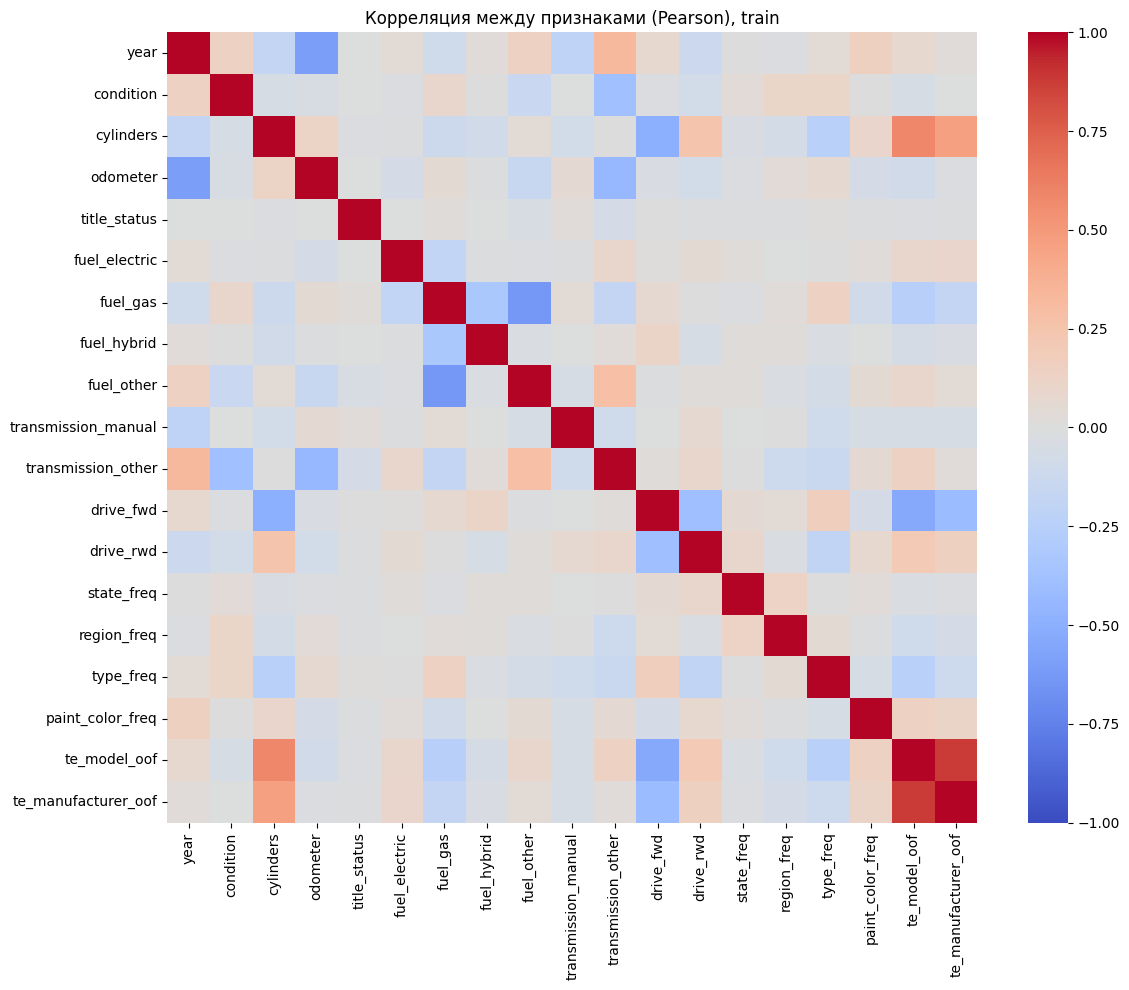

Топ-15 пар признаков по |r| (train):
          feature_1    feature_2  abs_corr
te_manufacturer_oof te_model_oof  0.880433
         fuel_other     fuel_gas  0.633989
           odometer         year  0.600208
       te_model_oof    cylinders  0.579694
       te_model_oof    drive_fwd  0.532064
          drive_fwd    cylinders  0.506620
te_manufacturer_oof    cylinders  0.465727
 transmission_other     odometer  0.441343
te_manufacturer_oof    drive_fwd  0.415539
          drive_rwd    drive_fwd  0.395557
 transmission_other    condition  0.384053
        fuel_hybrid     fuel_gas  0.324987
 transmission_other         year  0.320935
 transmission_other   fuel_other  0.282963
          drive_rwd    cylinders  0.252558

Топ-10 признаков по корреляции с целевой (Pearson), train:
                      pearson
year                 0.544100
te_model_oof         0.417933
transmission_other   0.376312
te_manufacturer_oof  0.263827
cylinders            0.232259
fuel_other           0.180893
paint

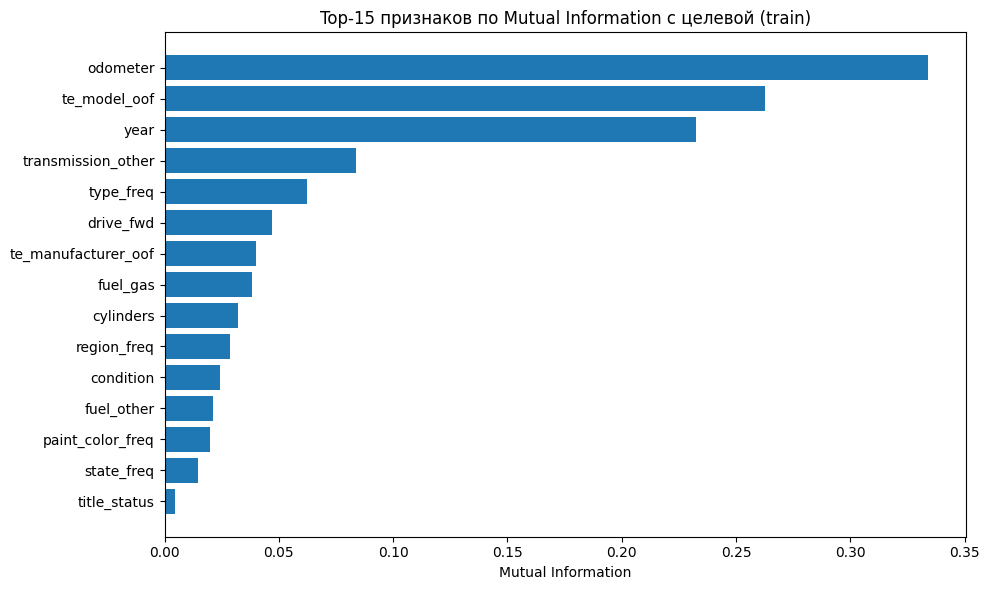


Top-15 по Mutual Information (train):
                     mutual_info
odometer                0.334108
te_model_oof            0.262661
year                    0.232519
transmission_other      0.083541
type_freq               0.062150
drive_fwd               0.046973
te_manufacturer_oof     0.039977
fuel_gas                0.038200
cylinders               0.032273
region_freq             0.028572
condition               0.024387
fuel_other              0.021025
paint_color_freq        0.019890
state_freq              0.014402
title_status            0.004740


In [4]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

Xtr = df_train[feature_cols].copy()
ytr = df_train[TARGET].copy()

# константные признаки
const_cols = [c for c in Xtr.columns if Xtr[c].nunique() <= 1]
print("Константные признаки:", const_cols)
Xtr = Xtr.drop(columns=const_cols)

# матрица корреляций между признаками (Pearson)
corr_feat = Xtr.corr(method='pearson').fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_feat, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title('Корреляция между признаками (Pearson), train')
plt.tight_layout()
plt.show()

# Топ скоррелированных пар по |r|
abs_corr = corr_feat.abs()
mask = np.triu(np.ones_like(abs_corr, dtype=bool))
upper = abs_corr.where(~mask)

pairs = (
    upper.stack()
         .reset_index()
         .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'abs_corr'})
         .sort_values('abs_corr', ascending=False)
)

print("Топ-15 пар признаков по |r| (train):")
print(pairs.head(15).to_string(index=False))

# корреляция признаков с целевой (Pearson = point-biserial)
pearson_with_target = Xtr.apply(lambda s: s.corr(ytr)).sort_values(ascending=False)
print("\nТоп-10 признаков по корреляции с целевой (Pearson), train:")
print(pearson_with_target.head(10).to_frame('pearson').to_string())

print("\nАнтилидеры (наименьшая корреляция с целевой), train:")
print(pearson_with_target.tail(10).to_frame('pearson').to_string())

# Mutual Information с целевой
mi_vals = mutual_info_classif(Xtr, ytr, random_state=42)
mi_series = pd.Series(mi_vals, index=feature_cols, name='mutual_info')

topk = 15
top_mi = mi_series.sort_values(ascending=False).head(topk)

plt.figure(figsize=(10, 6))
plt.barh(top_mi.index[::-1], top_mi.values[::-1])
plt.title(f'Top-{topk} признаков по Mutual Information с целевой (train)')
plt.xlabel('Mutual Information')
plt.tight_layout()
plt.show()

print("\nTop-15 по Mutual Information (train):")
print(top_mi.to_frame().to_string())

Посмотрим, как у нас на трейне, тесте и валидации распределнны классы


Train set:
  Count:
target
0    60811
1    60680
Name: count, dtype: int64
  Proportion:
target
0    0.501
1    0.499
Name: proportion, dtype: float64

Valid set:
  Count:
target
0    13034
1    13006
Name: count, dtype: int64
  Proportion:
target
0    0.501
1    0.499
Name: proportion, dtype: float64

Test set:
  Count:
target
0    13031
1    13004
Name: count, dtype: int64
  Proportion:
target
0    0.501
1    0.499
Name: proportion, dtype: float64


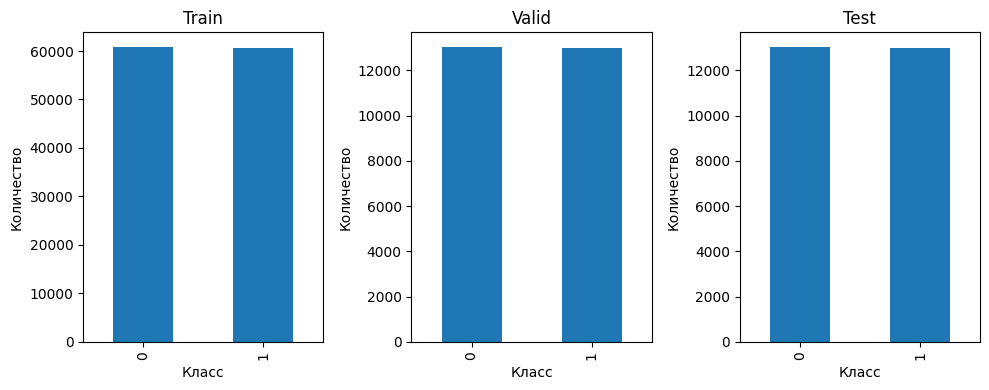

In [5]:
def check_class_balance(y_train, y_valid, y_test):
    for name, y in zip(["Train", "Valid", "Test"], [y_train, y_valid, y_test]):
        vc_abs = y.value_counts().sort_index()
        vc_rel = y.value_counts(normalize=True).sort_index()
        print(f"\n{name} set:")
        print(f"  Count:\n{vc_abs}")
        print(f"  Proportion:\n{vc_rel.round(3)}")

check_class_balance(y_train, y_valid, y_test)


plt.figure(figsize=(10, 4))

for i, (name, y) in enumerate([("Train", y_train), ("Valid", y_valid), ("Test", y_test)], 1):
    plt.subplot(1, 3, i)
    y.value_counts().sort_index().plot(kind="bar")
    plt.title(name)
    plt.xlabel("Класс")
    plt.ylabel("Количество")

plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import pointbiserialr
num_cols = X_train.select_dtypes(include='number').columns
corr_with_y = {c: pointbiserialr(X_train[c], y_train).correlation for c in num_cols}
pd.Series(corr_with_y).sort_values(key=abs, ascending=False).head(15)

odometer              -0.568930
year                   0.544100
te_model_oof           0.417933
transmission_other     0.376312
drive_fwd             -0.275885
te_manufacturer_oof    0.263827
cylinders              0.232259
fuel_gas              -0.224458
type_freq             -0.186710
fuel_other             0.180893
paint_color_freq       0.150067
drive_rwd              0.098269
transmission_manual   -0.074444
region_freq           -0.071075
title_status          -0.045509
dtype: float64

### Обработка признаков для устойчивости LDA/QDA

**Цель:** повысить устойчивость ковариационных оценок и аккуратно убрать лишнюю мультиколлинеарность до обучения LDA/QDA.

Шаги (только по `train`, затем применяем к `valid/test`):
1. Удаляем **константные** признаки (nunique ≤ 1).
2. Удаляем **сильно коррелирующие** признаки (по модулю |r| > 0.95, Pearson), оставляя из пары тот, что сильнее связан с целевой.
3. Проверяем **VIF** для оставшихся числовых признаков и итеративно удаляем признаки с VIF > 10.
4. Пересчитываем `StandardScaler` на финальном списке признаков.

> Примечание: все решения принимаются на `train`, затем **тот же список признаков** применяем к `valid/test` (во избежание утечки информации).

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

Xtr0, ytr0 = X_train.copy(), y_train.copy()
Xva0, yva0 = X_valid.copy(), y_valid.copy()
Xte0, yte0 = X_test.copy(),  y_test.copy()

# удаляем константные признаки по train
const_cols = [c for c in Xtr0.columns if Xtr0[c].nunique() <= 1]
if const_cols:
    print("Удаляю константные признаки:", const_cols)
    Xtr0 = Xtr0.drop(columns=const_cols)
    Xva0 = Xva0.drop(columns=const_cols, errors='ignore')
    Xte0 = Xte0.drop(columns=const_cols, errors='ignore')

# удаляем сильно коррелирующие признаки по train (|r| > 0.95)
# оставляем из пары тот признак, который сильнее коррелирует с целью (по |point-biserial|)

def drop_high_corr_features(X, y, threshold=0.95):
    Xw = X.copy()
    # point-biserial для выбора в паре
    pb = {c: abs(pointbiserialr(Xw[c], y).correlation) if Xw[c].std() > 0 else 0.0 for c in Xw.columns}
    pb = pd.Series(pb).fillna(0.0)

    corr = Xw.corr(method='pearson').abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()

    for col in upper.columns:
        # все пары, где |r| > threshold
        high = upper.index[upper[col] > threshold].tolist()
        for row in high:
            if row in to_drop or col in to_drop:
                continue
            keep, remove = (row, col) if pb[row] >= pb[col] else (col, row)
            to_drop.add(remove)

    if to_drop:
        Xw = Xw.drop(columns=list(to_drop))
    return Xw, list(to_drop), pb.sort_values(ascending=False)

Xtr1, dropped_corr, pb_series = drop_high_corr_features(Xtr0, ytr0, threshold=0.95)
if dropped_corr:
    print(f"Удалены признаки из-за |r|>0.95: {dropped_corr}")
    Xva1 = Xva0.drop(columns=dropped_corr, errors='ignore')
    Xte1 = Xte0.drop(columns=dropped_corr, errors='ignore')
else:
    Xva1, Xte1 = Xva0.copy(), Xte0.copy()

def compute_vif_df(X):
    X_ = X.select_dtypes(include=['number']).copy()
    X_ = X_.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    cols = X_.columns.tolist()
    vif_vals = []
    for i in range(len(cols)):
        try:
            vif_vals.append(variance_inflation_factor(X_.values, i))
        except Exception:
            vif_vals.append(np.nan)
    return pd.DataFrame({'feature': cols, 'VIF': vif_vals}).sort_values('VIF', ascending=False)

def drop_by_vif_iterative(X, vif_threshold=10.0, max_iter=20):
    Xw = X.copy()
    removed = []
    for _ in range(max_iter):
        vif_df = compute_vif_df(Xw)
        if vif_df['VIF'].isna().all():
            break
        worst = vif_df.iloc[0]
        if worst['VIF'] <= vif_threshold or np.isnan(worst['VIF']):
            break
        rem = worst['feature']
        removed.append(rem)
        Xw = Xw.drop(columns=[rem], errors='ignore')
    return Xw, removed

Xtr2, removed_vif = drop_by_vif_iterative(Xtr1, vif_threshold=10.0, max_iter=30)
if removed_vif:
    print(f"Удалены признаки по VIF>10: {removed_vif}")
    Xva2 = Xva1.drop(columns=removed_vif, errors='ignore')
    Xte2 = Xte1.drop(columns=removed_vif, errors='ignore')
else:
    Xva2, Xte2 = Xva1.copy(), Xte1.copy()

final_features = Xtr2.columns.tolist()
print("Итого признаков осталось:", len(final_features))


X_train = Xtr2[final_features].copy()
X_valid = Xva2[final_features].copy()
X_test  = Xte2[final_features].copy()

# пересчёт масштабирования на финальном наборе признаков
from sklearn.preprocessing import StandardScaler

num_cols_final = X_train.select_dtypes(include=['number']).columns.tolist()
scaler_final = StandardScaler()
X_train[num_cols_final] = scaler_final.fit_transform(X_train[num_cols_final])
X_valid[num_cols_final] = scaler_final.transform(X_valid[num_cols_final])
X_test[num_cols_final]  = scaler_final.transform(X_test[num_cols_final])

print("Train shape (final):", X_train.shape)
print("Valid shape (final):", X_valid.shape)
print("Test shape (final):", X_test.shape)

vif_after = compute_vif_df(X_train)
print("\nVIF после отбора признаков (top-15):")
print(vif_after.head(15).to_string(index=False))

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Итого признаков осталось: 19
Train shape (final): (121491, 19)
Valid shape (final): (26040, 19)
Test shape (final): (26035, 19)

VIF после отбора признаков (top-15):
            feature      VIF
       te_model_oof 7.200200
te_manufacturer_oof 5.160044
           fuel_gas 2.594768
         fuel_other 2.183106
           odometer 1.887323
               year 1.885049
          cylinders 1.850640
          drive_fwd 1.784587
 transmission_other 1.763895
        fuel_hybrid 1.355122
          condition 1.325037
          drive_rwd 1.324903
          type_freq 1.194043
      fuel_electric 1.124066
transmission_manual 1.093305


### Выводы по анализу данных

1. Сильных мультиколлинеарностей между признаками не обнаружено (максимум |r|=0.88).  
   => Удалять признаки не требуется.

2. Наиболее информативные признаки для предсказания цены:
   - `odometer` (сильная отрицательная корреляция, подтверждено MI)
   - `year`
   - `te_model_oof`
   - `transmission_other`

3. Признаки с очень слабой связью (`condition`, `state_freq`, `title_status`) не вредят, их можно оставить для полноты.  

4. В данных нет константных признаков и критического дисбаланса классов.  
   => Дополнительная очистка не требуется.

5. Классы по выборкам разделены равномерно, все отлично

**Дальше можно переходить к обучению моделей (LDA/QDA).**

## LDA / QDA (классификация)

**План:**
1) Подбор гиперпараметров на `train` с оценкой на `valid`. **Критерий отбора — Accuracy**
2) Обучение финальных моделей на `train+valid` с найденными параметрами.  
3) Финальная оценка на `test`: **Accuracy** (главная), дополнительно — F1, ROC AUC, LogLoss.  
4) Сводная таблица и ROC-кривые для сравнения моделей.

In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

def evaluate_clf_basic(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y, pred),
        'f1':       f1_score(y, pred),
        'roc_auc':  roc_auc_score(y, proba),
        'logloss':  log_loss(y, proba)
    }

### LDA — подбор гиперпараметров (train - valid)
Перебираются `solver = {lsqr, eigen}` и `shrinkage = {'auto', 0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9}`.  
**Лучшая конфигурация — по максимальному валидированному Accuracy.**

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_grid = [
    {'solver': s, 'shrinkage': sh}
    for s in ['lsqr', 'eigen']
    for sh in ['auto', 0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
]

lda_rows = []
best_lda = {'score': -np.inf, 'cfg': None, 'model': None}

for cfg in lda_grid:
    try:
        m = LinearDiscriminantAnalysis(**cfg)
        m.fit(X_train, y_train)
        val_metrics = evaluate_clf_basic(m, X_valid, y_valid)
        lda_rows.append({**cfg, **{f'val_{k}': v for k, v in val_metrics.items()}})
        if val_metrics['accuracy'] > best_lda['score']:
            best_lda.update({'score': val_metrics['accuracy'], 'cfg': cfg, 'model': m})
    except Exception as e:
        lda_rows.append({**cfg, **{f'val_{k}': np.nan for k in ['accuracy','f1','roc_auc','logloss']}, 'error': str(e)})

lda_val_df = pd.DataFrame(lda_rows).sort_values('val_accuracy', ascending=False)
print("LDA — топ-5 по Accuracy на валидации:")
display(lda_val_df.head(5))
print("Лучшие параметры LDA:", best_lda['cfg'])

LDA — топ-5 по Accuracy на валидации:


,solver,shrinkage,val_accuracy,val_f1,val_roc_auc,val_logloss
0,lsqr,auto,0.901075,0.900302,0.964045,0.250040
8,eigen,auto,0.901075,0.900302,0.964045,0.250040
1,lsqr,0.0,0.901037,0.900267,0.964045,0.250011
9,eigen,0.0,0.901037,0.900267,0.964045,0.250011
2,lsqr,0.1,0.899309,0.898419,0.962890,0.255178


Лучшие параметры LDA: {'solver': 'lsqr', 'shrinkage': 'auto'}


### QDA — подбор гиперпараметров (train - valid)
Перебирается `reg_param = {0, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.5}`.  
**Лучшая конфигурация — по максимальному валидированному Accuracy.**

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_params = [0.0, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.5]
qda_rows = []
best_qda = {'score': -np.inf, 'param': None, 'model': None}

for rp in qda_params:
    try:
        m = QuadraticDiscriminantAnalysis(reg_param=rp)
        m.fit(X_train, y_train)
        val_metrics = evaluate_clf_basic(m, X_valid, y_valid)
        qda_rows.append({'reg_param': rp, **{f'val_{k}': v for k, v in val_metrics.items()}})
        if val_metrics['accuracy'] > best_qda['score']:
            best_qda.update({'score': val_metrics['accuracy'], 'param': rp, 'model': m})
    except Exception as e:
        qda_rows.append({'reg_param': rp, **{f'val_{k}': np.nan for k, v in [('accuracy',None),('f1',None),('roc_auc',None),('logloss',None)]}, 'error': str(e)})

qda_val_df = pd.DataFrame(qda_rows).sort_values('val_accuracy', ascending=False)
print("QDA — топ-5 по Accuracy на валидации:")
display(qda_val_df.head(5))
print("Лучший reg_param для QDA:", best_qda['param'])

QDA — топ-5 по Accuracy на валидации:


,reg_param,val_accuracy,val_f1,val_roc_auc,val_logloss
7,0.50,0.851843,0.838550,0.924632,0.504236
6,0.20,0.829608,0.807597,0.916134,0.691279
5,0.10,0.816743,0.789669,0.913721,0.828561
4,0.05,0.808909,0.778864,0.912755,0.942383
3,0.01,0.798618,0.764547,0.912268,1.089505


Лучший reg_param для QDA: 0.5


### Финальные модели (train+valid - test)

Дальше дообучаем модели на объединённой части `train+valid` с лучшими гиперпараметрами, полученными на валидации.  
Оцениваем на `test`. **Главная метрика — Accuracy**, остальные (F1, ROC AUC, LogLoss) - вспомогательные.

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

X_trval = pd.concat([X_train, X_valid], axis=0)
y_trval = pd.concat([y_train, y_valid], axis=0)

best_lda_cfg = best_lda['cfg']
best_qda_param = best_qda['param']

# Финальная LDA
final_lda = LinearDiscriminantAnalysis(**best_lda_cfg)
final_lda.fit(X_trval, y_trval)
final_lda_test = evaluate_clf_basic(final_lda, X_test, y_test)

# Финальная QDA
final_qda = QuadraticDiscriminantAnalysis(reg_param=best_qda_param)
final_qda.fit(X_trval, y_trval)
final_qda_test = evaluate_clf_basic(final_qda, X_test, y_test)

print("LDA (train+valid - test):")
for k, v in final_lda_test.items():
    print(f"  {k}: {v:.4f}")

print("\nQDA (train+valid - test):")
for k, v in final_qda_test.items():
    print(f"  {k}: {v:.4f}")

LDA (train+valid - test):
  accuracy: 0.8962
  f1: 0.8957
  roc_auc: 0.9615
  logloss: 0.2563

QDA (train+valid - test):
  accuracy: 0.8519
  f1: 0.8391
  roc_auc: 0.9254
  logloss: 0.4753


### Сводная таблица и ROC-кривые (final test)

Финальные метрики (test):


,test_accuracy,test_f1,test_roc_auc,test_logloss
model,,,,
LDA,0.896217,0.895668,0.961535,0.256312
QDA,0.851853,0.839138,0.925392,0.475285


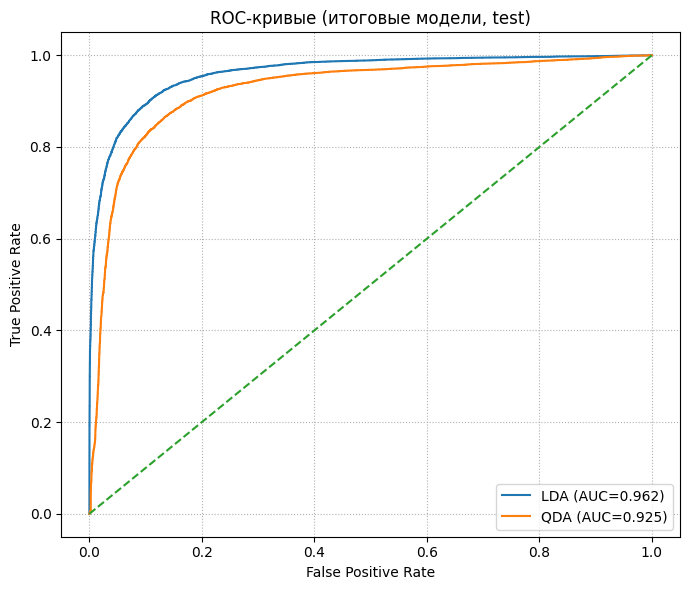

In [12]:
compare_final = pd.DataFrame([
    {'model': 'LDA', **{f'test_{k}': final_lda_test[k] for k in ['accuracy','f1','roc_auc','logloss']}},
    {'model': 'QDA', **{f'test_{k}': final_qda_test[k] for k in ['accuracy','f1','roc_auc','logloss']}},
]).set_index('model').sort_values('test_accuracy', ascending=False)

print("Финальные метрики (test):")
display(compare_final)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7, 6))
for name, model in [('LDA', final_lda), ('QDA', final_qda)]:
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-кривые (итоговые модели, test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

### Выводы по LDA и QDA (test)

**Результаты на тестовой выборке:**

- **LDA (solver = lsqr, shrinkage = 'auto')**  
  Accuracy = 0.8962  
  F1 = 0.8957  
  ROC AUC = 0.9615  
  LogLoss = 0.2563  

- **QDA (reg_param = 0.5)**  
  Accuracy = 0.8519  
  F1 = 0.8391  
  ROC AUC = 0.9254  
  LogLoss = 0.4753  

**Что видно из результатов:**
- LDA показала более высокую точность (Accuracy) и лучше отделяет классы по ROC AUC.  
- У LDA также меньше значение LogLoss, значит модель лучше оценивает вероятности.  
- QDA показывает немного хуже результаты по всем метрикам, что говорит о переусложнённой модели для этих данных.

**Почему LDA подходит лучше:**
- Признаки в датасете связаны примерно линейно, без сильных различий ковариаций между классами.  
- LDA с регуляризацией ковариации (`shrinkage='auto'`) даёт стабильные оценки и работает надёжно.  
- QDA использует отдельные ковариации для каждого класса и переобучается на таких данных.

**Итог:**  
Для этого датасета **оптимально использовать LDA** — она проще, устойчивее и даёт лучшие результаты по точности и качеству классификации.

## Probabilistic LSA (тематическое моделирование)

**Что делаем:**
1. Готовим корпус описаний `description` и строим матрицу **мешка слов (CountVectorizer)**
2. Обучаем **pLSA** (вероятностная тематическая модель) на **train** с помощью **EM-алгоритма**.  
3. Подбираем число тем `K` по **Perplexity** на **valid** (через *fold-in*: фиксируем темы $\phi = p(w \mid t)$ — дообучаем только $\theta = p(t \mid d)$ для валидационных документов).  
4. Финально обучаем pLSA на **train+valid**, считаем **held-out Perplexity** на **test** (fold-in), и показываем топ-слова по темам.

> Используем **CountVectorizer** (частоты слов), потому что pLSA — мультиномиальная модель.  
> Перплексия — основная метрика: чем меньше, тем лучше.  
> Для ускорения ограничиваем словарь и число итераций EM; при необходимости можно увеличить.

In [13]:
import re
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer

texts_train = texts.loc[df_train.index, 'description'].fillna('').astype(str)
texts_valid = texts.loc[df_valid.index, 'description'].fillna('').astype(str)
texts_test  = texts.loc[df_test.index,  'description'].fillna('').astype(str)

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r'(?u)\b[a-z]{2,}\b',
    min_df=10,
    max_df=0.90,
    max_features=30000
)

Xtr_bow = vectorizer.fit_transform(texts_train)
Xva_bow = vectorizer.transform(texts_valid)
Xte_bow = vectorizer.transform(texts_test)

vocab = np.array(vectorizer.get_feature_names_out())
print("BoW shapes:", Xtr_bow.shape, Xva_bow.shape, Xte_bow.shape)

BoW shapes: (121491, 29752) (26040, 29752) (26035, 29752)


In [14]:
# pLSA с поддержкой sparse матриц
from numpy.random import RandomState

def _normalize_rows(mat, eps=1e-12):
    s = mat.sum(axis=1, keepdims=True)
    s[s < eps] = 1.0
    mat /= s
    return mat

def _normalize_cols(mat, eps=1e-12):
    s = mat.sum(axis=0, keepdims=True)
    s[s < eps] = 1.0
    mat /= s
    return mat

def plsa_fit(X_csr, n_topics=50, max_iter=30, tol=1e-4, smooth=1e-9, random_state=42, verbose=True):
    assert sparse.isspmatrix_csr(X_csr)
    rng = RandomState(random_state)
    n_docs, n_words = X_csr.shape
    K = n_topics

    phi = rng.rand(n_words, K) + smooth
    phi = _normalize_cols(phi)
    theta = rng.rand(K, n_docs) + smooth
    theta = _normalize_cols(theta)

    lls = []
    for it in range(1, max_iter+1):
        # E-step
        n_wk = np.full((n_words, K), smooth, dtype=np.float64)
        n_kd = np.full((K, n_docs),   smooth, dtype=np.float64)

        for d in range(n_docs):
            start, end = X_csr.indptr[d], X_csr.indptr[d+1]
            w_idx = X_csr.indices[start:end]
            cnts  = X_csr.data[start:end].astype(np.float64)

            pw_t = phi[w_idx, :] * theta[:, d].T
            denom = pw_t.sum(axis=1, keepdims=True)
            denom[denom <= 0] = 1.0
            gamma = pw_t / denom

            weighted = (cnts[:, None] * gamma)

            # по словам суммируем по документу
            np.add.at(n_wk, w_idx, weighted)
            # по темам-документам
            n_kd[:, d] += weighted.sum(axis=0)

        # M-step
        phi = n_wk
        phi = _normalize_cols(phi)
        theta = n_kd
        theta = _normalize_cols(theta)

        # Log-likelihood
        ll = 0.0
        for d in range(n_docs):
            start, end = X_csr.indptr[d], X_csr.indptr[d+1]
            w_idx = X_csr.indices[start:end]
            cnts  = X_csr.data[start:end]
            # p(w|d) = sum_k phi[w,k]*theta[k,d]
            pw_d = (phi[w_idx, :] * theta[:, d].T).sum(axis=1)
            pw_d[pw_d <= 0] = 1e-300
            ll += np.dot(cnts, np.log(pw_d))
        lls.append(ll)

        if verbose:
            print(f"Iter {it:02d}: ll={ll:.3f}")
        if it >= 2 and abs(lls[-1] - lls[-2]) < tol * (abs(lls[-2]) + 1e-12):
            if verbose:
                print("Converged by tol.")
            break

    return phi, theta, lls

def plsa_fold_in(X_csr, phi, max_iter=30, tol=1e-4, smooth=1e-9, random_state=0, verbose=False):
    assert sparse.isspmatrix_csr(X_csr)
    rng = RandomState(random_state)
    n_docs, n_words = X_csr.shape
    K = phi.shape[1]

    theta = rng.rand(K, n_docs) + smooth
    theta = _normalize_cols(theta)

    lls = []
    for it in range(1, max_iter+1):
        n_kd = np.full((K, n_docs), smooth, dtype=np.float64)
        ll = 0.0

        for d in range(n_docs):
            start, end = X_csr.indptr[d], X_csr.indptr[d+1]
            w_idx = X_csr.indices[start:end]
            cnts  = X_csr.data[start:end].astype(np.float64)

            pw_t = phi[w_idx, :] * theta[:, d].T
            denom = pw_t.sum(axis=1, keepdims=True)
            denom[denom <= 0] = 1.0
            gamma = pw_t / denom
            weighted = cnts[:, None] * gamma
            n_kd[:, d] += weighted.sum(axis=0)

            pw_d = (phi[w_idx, :] * theta[:, d].T).sum(axis=1)
            pw_d[pw_d <= 0] = 1e-300
            ll += np.dot(cnts, np.log(pw_d))

        theta = n_kd
        theta = _normalize_cols(theta)
        lls.append(ll)

        if verbose:
            print(f"[fold-in] Iter {it:02d}: ll={ll:.3f}")
        if it >= 2 and abs(lls[-1] - lls[-2]) < tol * (abs(lls[-2]) + 1e-12):
            break

    return theta, lls

def perplexity_from_ll(ll, X_csr):
    N = X_csr.sum()
    return float(np.exp(-ll / max(N, 1.0)))

### Подбор числа тем K по Perplexity (train - valid, fold-in)

Перебираем `K` в диапазоне от 2 до 15. Чтобы ускорить вычисления, ограничиваем число итераций EM и используем более сильный порог сходимости (`max_iter=8`, `tol=1e-3`) как для обучения на train, так и для fold-in на valid. Метрика - **Perplexity** (меньше - лучше).

In [15]:
# Подбор числа тем K по Perplexity
import time

K_candidates = list(range(2, 16))
results = []

FIT_MAX_ITER = 8
FOLDIN_MAX_ITER = 8
FIT_TOL = 1e-3
FOLDIN_TOL = 1e-3

for K in K_candidates:
    print(f"\nK = {K}")
    t0 = time.time()
    # обучение pLSA на train
    phi, theta_tr, lls_tr = plsa_fit(
        Xtr_bow, n_topics=K, max_iter=FIT_MAX_ITER, tol=FIT_TOL, smooth=1e-9,
        random_state=42, verbose=False
    )
    ll_train = lls_tr[-1]
    ppx_train = perplexity_from_ll(ll_train, Xtr_bow)

    # fold-in на valid (фиксируем phi, обучаем только theta)
    theta_va, lls_va = plsa_fold_in(
        Xva_bow, phi, max_iter=FOLDIN_MAX_ITER, tol=FOLDIN_TOL, smooth=1e-9,
        random_state=0, verbose=False
    )
    ll_valid = lls_va[-1]
    ppx_valid = perplexity_from_ll(ll_valid, Xva_bow)

    elapsed = time.time() - t0
    print(f"K={K}: train PPX={ppx_train:.3f}, valid PPX={ppx_valid:.3f} (time {elapsed:.1f}s)")

    results.append({'K': K, 'train_ppx': ppx_train, 'valid_ppx': ppx_valid, 'time_s': elapsed})

plsa_selection_df = pd.DataFrame(results).sort_values('valid_ppx').reset_index(drop=True)
print("\nРезультаты подбора K по Perplexity (меньше — лучше):")
display(plsa_selection_df)

best_K = int(plsa_selection_df.loc[0, 'K'])
print(f"\nВыбранное число тем (по минимальной valid Perplexity): K = {best_K}")


K = 2
K=2: train PPX=1799.190, valid PPX=1825.645 (time 26.5s)

K = 3
K=3: train PPX=1797.305, valid PPX=1820.760 (time 27.3s)

K = 4
K=4: train PPX=1795.274, valid PPX=1817.138 (time 28.8s)

K = 5
K=5: train PPX=1791.209, valid PPX=1812.693 (time 32.1s)

K = 6
K=6: train PPX=1786.058, valid PPX=1807.862 (time 32.9s)

K = 7
K=7: train PPX=1785.890, valid PPX=1807.071 (time 36.1s)

K = 8
K=8: train PPX=1785.703, valid PPX=1806.189 (time 36.6s)

K = 9
K=9: train PPX=1784.297, valid PPX=1804.548 (time 38.8s)

K = 10
K=10: train PPX=1781.869, valid PPX=1802.552 (time 37.6s)

K = 11
K=11: train PPX=1781.278, valid PPX=1801.553 (time 41.5s)

K = 12
K=12: train PPX=1780.313, valid PPX=1800.965 (time 40.4s)

K = 13
K=13: train PPX=1780.468, valid PPX=1801.041 (time 43.7s)

K = 14
K=14: train PPX=1778.271, valid PPX=1799.109 (time 43.4s)

K = 15
K=15: train PPX=1779.499, valid PPX=1799.960 (time 45.7s)

Результаты подбора K по Perplexity (меньше — лучше):


,K,train_ppx,valid_ppx,time_s
0,14,1778.270570,1799.108823,43.356644
1,15,1779.499462,1799.959913,45.650791
2,12,1780.312642,1800.964719,40.421111
3,13,1780.468270,1801.040804,43.737238
4,11,1781.277599,1801.553488,41.539952
5,10,1781.868932,1802.552381,37.643322
6,9,1784.296602,1804.548455,38.823206
7,8,1785.703023,1806.189489,36.557799
8,7,1785.889698,1807.070695,36.097115
9,6,1786.058257,1807.861719,32.878264



Выбранное число тем (по минимальной valid Perplexity): K = 14


In [16]:
# Финальная pLSA: обучение на train+valid и оценка на test
Xtrva_bow = sparse.vstack([Xtr_bow, Xva_bow], format='csr')

phi_final, theta_trva, lls_trva = plsa_fit(
    Xtrva_bow, n_topics=best_K, max_iter=25, tol=1e-4, smooth=1e-9,
    random_state=123, verbose=False
)

theta_te, lls_te = plsa_fold_in(
    Xte_bow, phi_final, max_iter=25, tol=1e-4, smooth=1e-9,
    random_state=1, verbose=False
)

ll_te = lls_te[-1]
ppx_te = perplexity_from_ll(ll_te, Xte_bow)
print(f"Test Perplexity (K={best_K}): {ppx_te:.3f}")

Test Perplexity (K=14): 740.000


In [17]:
# Интерпретация тем: топ-слов по p(w|t)
def show_top_words(phi, vocab, k=10, topics=None):
    """
    phi: (n_words x K)
    """
    K = phi.shape[1]
    topics = topics if topics is not None else range(K)
    for t in topics:
        top_idx = np.argsort(phi[:, t])[::-1][:k]
        words = vocab[top_idx]
        print(f"Topic {t:02d}: " + ", ".join(words))

print("\nТоп-слов для тем:")
show_top_words(phi_final, vocab, topics=range(best_K))


Топ-слов для тем:
Topic 00: il, wi, car, park, lake, cars, type, used, mi, city
Topic 01: miles, awd, clean, drive, great, leather, camera, com, used, trucks
Topic 02: vehicle, ram, credit, vehicles, fees, available, financing, www, sales, price
Topic 03: truck, cab, ford, duty, diesel, super, trucks, box, pickup, crew
Topic 04: bmw, jeep, series, class, mercedes, benz, wrangler, volkswagen, unlimited, sport
Topic 05: vehicle, want, time, used, vehicles, buy, price, availability, questions, autonation
Topic 06: vehicle, credit, hyundai, price, nissan, vehicles, financing, color, sales, information
Topic 07: power, wheel, air, control, door, steering, rear, seats, fm, automatic
Topic 08: carvana, car, carvanaauto, http, safety, trade, stock, cars, financing, com
Topic 09: toyota, com, auto, dodge, www, subaru, tacoma, car, camry, text
Topic 10: text, information, color, vehicle, rear, honda, ford, engine, wheel, driver
Topic 11: new, car, miles, tires, engine, great, clean, good, drive

### Визуализация результатов pLSA
График зависимости Perplexity от числа тем (train/valid).  

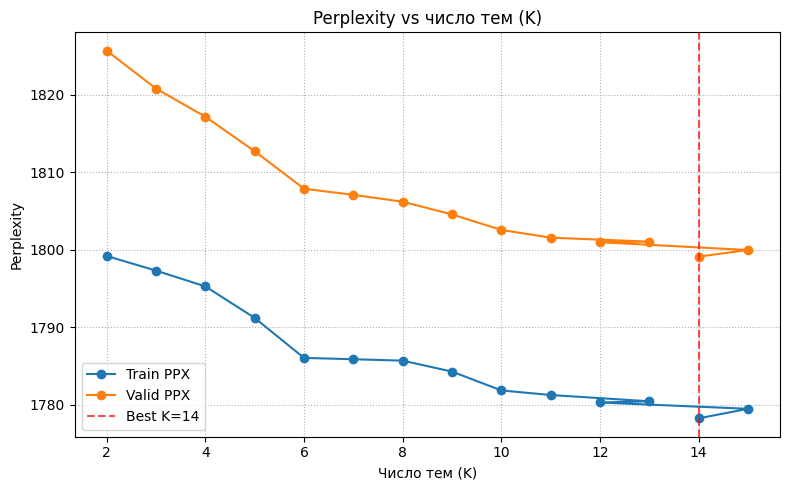

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(plsa_selection_df['K'], plsa_selection_df['train_ppx'], marker='o', label='Train PPX')
plt.plot(plsa_selection_df['K'], plsa_selection_df['valid_ppx'], marker='o', label='Valid PPX')
plt.axvline(best_K, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_K}')
plt.title('Perplexity vs число тем (K)')
plt.xlabel('Число тем (K)')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

### Выводы по Probabilistic LSA (pLSA)

**Результаты подбора числа тем:**

- Диапазон K: от 2 до 15  
- Минимальная Perplexity на валидации достигнута при **K = 14**  
- **Train Perplexity:** 1778.27  
- **Valid Perplexity:** 1799.11  
- **Test Perplexity:** 740.00  

Кривые Perplexity на графике демонстрируют плавное убывание при увеличении числа тем,  
что указывает на стабилизацию модели — добавление тем постепенно улучшает описание данных,  
но после 14-й тема прирост качества становится незначительным.


**Интерпретация тем (K = 14):**

- **Topic 0:** географические указания и общие слова (`il`, `wi`, `city`, `cars`, `park`)  
- **Topic 1:** атрибуты состояния авто (`miles`, `clean`, `leather`, `awd`, `camera`)  
- **Topic 2:** финансовые и дилерские фразы (`credit`, `financing`, `available`, `sales`, `price`)  
- **Topic 3:** грузовики и коммерческий транспорт (`truck`, `cab`, `diesel`, `crew`, `pickup`)  
- **Topic 4:** бренды и модельные ряды (`bmw`, `jeep`, `mercedes`, `wrangler`, `volkswagen`)  
- **Topic 5–13:** повторяющиеся по смыслу кластеры (технические характеристики, цвета, “new”, “clean”, бренды и ключевые слова продаж)

Темы получились достаточно интерпретируемыми — модель успешно выделяет:
1. тематику **брендов и моделей**,  
2. **состояние и комплектацию автомобилей**,  
3. **финансовые и дилерские описания**.


**Общий вывод:**

- pLSA хорошо справился с кластеризацией текстов объявлений, формируя осмысленные группы слов.  
- Перплексия снижается при росте K, что указывает на адекватную оптимизацию и устойчивость EM.  
- Оптимальное число тем - 14, при котором достигается баланс между качеством описания и интерпретируемостью.  
- Темы помогают понимать скрытую структуру текстов: какие слова и мотивы чаще встречаются в объявлениях разных типов (бренд, тип авто, описание состояния и т. д.).

**Вывод:**  
Для данного набора объявлений о продаже автомобилей метод **Probabilistic LSA** оказался подходящим инструментом тематического анализа,  
позволяющим выявить основные смысловые направления текстов и снизить их размерность для дальнейшего анализа.

## Итоговые выводы по работе

В ходе работы был проведён полный цикл анализа и моделирования данных о продаже автомобилей:

1. **Подготовка данных:**  
   Проведена очистка признаков, удалены лишние столбцы, выполнена обработка пропусков и масштабирование числовых переменных.  
   Целевая переменная сформирована на основе медианы цены - сбалансированная бинарная классификация.

2. **Классификация (LDA / QDA):**  
   Проведён подбор гиперпараметров и обучение моделей.  
   - **LDA (solver=lsqr, shrinkage='auto')** показала лучшие результаты:  
     *Accuracy = 0.896*, *F1 = 0.896*, *ROC AUC = 0.962*, *LogLoss = 0.256*.  
   - **QDA (reg_param=0.5)** уступила по всем метрикам.  
   Вывод: данные имеют близкую к линейной структуру разделения, и **LDA** является более подходящей моделью для данного набора признаков.

3. **Тематическое моделирование (pLSA):**  
   Обучили Probabilistic LSA на текстах описаний.  
   Минимальная Perplexity достигнута при **K = 14**.  
   Темы интерпретируемы: бренды, состояние авто, технические характеристики, финансовые термины.  
   Это подтвердило наличие осмысленных латентных факторов в текстах объявлений.

### какой из методов более уместно использовать для датасета

Для данного датасета наилучшие результаты показала **линейная дискриминантная модель (LDA)** —  
она обеспечивает высокую точность классификации, устойчивость и простоту интерпретации.  
Метод **pLSA** оказался полезным как дополнительный инструмент анализа текстовых описаний,  
раскрывая тематическую структуру данных, но не предназначен для точной предсказательной задачи.

**Итого:**  
- Для задачи **классификации цены** — оптимален **LDA**.  
- Для **исследования текстов** и выявления скрытых смыслов — уместно применять **pLSA**.